# **Exercise 4 - Group 08 (Academic Year 2022-2023)**
 
- Erica Brisigotti (2097202)
- Ekaterina Chueva (2072050)
- Sofia Pacheco Garcia (2070771)
- Nadillia Sahputra (2070770)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
from sklearn.utils import shuffle 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
plt.rcParams['font.size'] = 14

ModuleNotFoundError: No module named 'numpy'

First of all, we generate/upload the data: we generate a lot of it since we are going to need it later.

In [2]:
np.random.seed(123)

CASE = 1

S = 2
N = 20000
N_train = int(N/2)
N_test = int(N/2)
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)
z = 2*x+0.5
e = 2*x-0.5
a = -0.5*x+0.2
b = -0.5*x-0.1

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        if x[n,1]<z[n,0] and x[n,1]>e[n,0]: y[n]=1
        if x[n,1]<a[n,0] and x[n,1]>b[n,0]: y[n]=1
            
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

    

For the first part of the analysis, we look for the best combination of parameters of the DNN (that will be later compared to XGBoost): to do

In [3]:
i_i = 2000 
X_i,Y_i = shuffle(x,y)
X_i = X_i[:i_i]
Y_i = Y_i[:i_i]

N_train = int(i_i/2)
N_test  = i_i - N_train 

x_train,y_train = X_i[:N_train],Y_i[:N_train]
x_test,y_test = X_i[(N_train-1):],Y_i[(N_train-1):]
L=len(x_train[0])

We then define a custom function for plotting:

In [4]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("feature 0")
    plt.ylabel("feature 1")

and use said function to represent the generated data by color-coding it based on the labels.

[ 0.78587674 -0.85544266] 1
[-1.09259419  0.20525908] 0
[ 0.87787588 -0.30757416] 1
[1.92305679 0.73931895] 0
[-0.07627239 -0.43152993] 1


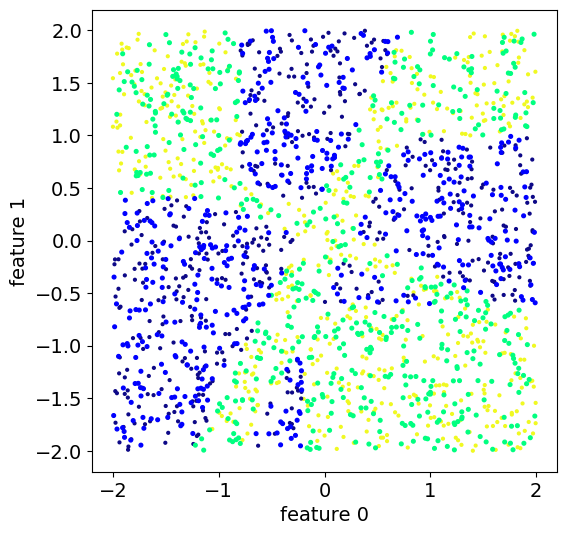

In [5]:
for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

We then define a function to summarize the xbgoost classification, which is the first of two ML algorithm we use.

In [6]:
def classify(clf=GradientBoostingClassifier(),show=False, boost = True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    # boost = True if use XGboost and false if Neural Network
    if boost:
        clf.fit(x_train,y_train)
        acc=clf.score(x_test, y_test)    
    else:
        fit_dnn  = clf.fit(x_train, y_train, epochs = 200, batch_size = 50, validation_data=(x_test,y_test), verbose=0)
        y_hat = clf.predict(x_test)
        acc = (fit_dnn.history['accuracy'])[-1]     

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1    
    y_plot= clf.predict(x_plot)
    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if boost:
        if show:      
            dump_list = clf.get_booster().get_dump()
            num_trees = len(dump_list)
            print("num_trees=",num_trees)

            fig, AX = plt.subplots(3,1,figsize=(30, 30))
            for i in range(min(3,num_trees)):
                ax=AX[i]
                plot_tree(clf, num_trees=i, ax=ax)
            fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
            plt.show()
    return acc

The second ML strategy used in this analysis is a DNN, of which we define the model

## 1. XGBoost vs DNN for classification
Compare the performances of XGBoost with those of a feed-forward neural network (NN). Take a labeled dataset (two categories) that is simple enough for analysis in a reasonable time. As usual, separate the training and the test set. Compare the accuracy of the two methods by varying the number of data samples in the training set

First of all, we define the DNN model:

In [7]:
def mod(optimizer='sgd', activation='elu', neurons=15):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=200
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Before comparing the DNN to other methods, we find the the combination of parameters for the DNN that performs best (with highest accuracy) for this dataset: we do this via GridSearch for an intermidiate size of the input (of 2000 points):

In [8]:
# fix random seed for reproducibility
np.random.seed(2072050)
import tensorflow.random as tf_r
tf_r.set_seed(2072050)

# create model

model = KerasClassifier(model=mod, epochs=100, batch_size=50, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = ['sigmoid','relu','elu']
neurons = [10,15,20]

param_grid = dict(model__optimizer=optimizer, model__activation = activation, model__neurons = neurons)
grid = GridSearchCV(estimator=mod, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results_DNN = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                     pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results = results.sort_values(by=['Accuracy'], ascending = False)
print("the best performing combinations of parameters are (from highest to lowest accuracy): ")
results_DNN.head()

/tmp/ipykernel_21986/403307154.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(model=mod, epochs=100, batch_size=50, verbose=1)


AttributeError: 'KerasClassifier' object has no attribute '__call__'

In [ ]:
print('the optimal optimizer for the DNN is: ',results_DNN['optimizer'].head(1))
print('the optimal activation function for the DNN is: ',results_DNN['activation'].head(1))
print('the optimal number of neurons for the inner layers of the DNN is: ',results_DNN['neurons'].head(1))

We now compare the performance of the classification done by DNN (with its optimal parameters) vs XGBoost algorithms: we evaluate such performance for different sizes of the analyzed dataset.

In [ ]:
size = np.array([500,1000,5000,10000,20000])
acc_DNN = np.zeros(5)
acc_XGBC = np.zeros(5)
acc_XGBADA = np.zeros(5)

for idx,i in enumerate(size):
    print('index', idx)
    print('i', i)
    X,Y = shuffle(x,y)
    X = X[:i-1]
    Y = Y[:i-1]

    N_train = int(i/2)
    N_test  = i - N_train 
    
    x_train,y_train = X[:N_train],Y[:N_train]
    x_test,y_test = X[(N_train-1):],Y[(N_train-1):]
    L=len(x_train[0])
    model = mod(optimizer='Adam', activation = 'elu', neurons=20) # INSERT OPTIMAL COMBINATION OF PARAMETERS FROM BEFOREHAND
    temp_1=classify(clf=model, boost=False)
    temp_2=classify(clf =XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3),show=False)
    temp_3=classify(clf=AdaBoostClassifier())
    acc_DNN[idx]=temp_1
    acc_XGBC[idx]=temp_2
    acc_XGBADA[idx]=temp_3
    print(acc_DNN)
    print(acc_XGBC)
    print(acc_XGBADA)

In [ ]:
size = np.array([500,1000,5000,10000,20000])
fig, ax= plt.subplots()
ax.plot(size, acc_DNN, label='DNN')
ax.plot(size, acc_XGBC, label='XGB_Classifier')
ax.plot(size, acc_XGBADA, label='XGB_ADA')
ax.set_xlabel('size of dataset')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.grid()
ax.legend()

From looking at the graph above, we see that the most accurate classification algorithm is:
- ?? for moderate dimensions of the dataset (< ??) 
- ?? for higher dimensions of the dataset (> ??)

## 2. GridSearch for XGBoost
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good accuracy

In [ ]:
estimator = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)
parameters = { 'reg_lambda': [1, 10,50], 'gamma': [0,0.01,0.5], 'n_estimators': range(60, 220, 40)  }
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'roc_auc', n_jobs = 10,cv = 10,verbose=2)
grid_result = grid_search.fit(x_train, y_train)
# summarize all results in dataframe
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results = results.sort_values(by=['Accuracy'], ascending = False)
print("the best performing combinations of parameters are (from highest to lowest accuracy): ")
results.head()

In [ ]:
print('the optimal number of estimators is: ',results['n_estimators'].head(1))
print('the optimal value of parameter lambda is: ',results['reg_lambda'].head(1))
print('the optimal value of parameter gamma is: ',results['gamma'].head(1))
print('the classification obtained with the optimal combination of parameters is:')
classify(XGBClassifier(seed=1, objective='binary:logistic',
                       reg_lambda = results['reg_lambda'].head(1), 
                       n_estimators = results['n_estimators'].head(1),
                       gamma = results['gamma'].head(1) ),show=True)